In [47]:
import numpy as np
import pandas as pd
from scipy.integrate import nquad
from scipy.stats import entropy, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec


## Plot functions

In [80]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

def plot_3joint_pairs(df):
    n_dim = df.shape[1]-1 # - 1 for the label
    x0 = 1
    x1 = n_dim//2
    x2 = n_dim-1
    g0 = sns.JointGrid(x=x0, y=x0-1, data=df,  hue='y')
    g0.plot_joint(sns.scatterplot, legend='brief')
    g0.plot_marginals(sns.histplot, kde=True, color='k')

    g1 = sns.JointGrid(x=x1, y=x1-1, data=df, hue='y')
    g1.plot_joint(sns.scatterplot, legend='brief', hue='y')
    g1.plot_marginals(sns.histplot, kde=True, color='k')

    g2 = sns.JointGrid(x=x2, y=x2-1, data=df, hue='y')
    g2.plot_joint(sns.scatterplot, legend='brief', hue='y')
    g2.plot_marginals(sns.histplot, kde=True, color='k')

    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 3)

    mg0 = SeabornFig2Grid(g0, fig, gs[0])
    mg1 = SeabornFig2Grid(g1, fig, gs[1])
    mg2 = SeabornFig2Grid(g2, fig, gs[2])
    gs.tight_layout(fig)

    plt.show()

# plot_3joint_pairs(df)
        

In [72]:
def _moving_avg_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    cov_matrix = rho ** np.abs(i - j)

    # Apply the banding condition
    cov_matrix[abs(i - j) > 1] = 0
    return cov_matrix


def _autoregressive_cov(n_dim, rho):
    # Create a meshgrid of indices
    i, j = np.meshgrid(np.arange(1, n_dim + 1), np.arange(1, n_dim + 1), indexing="ij")

    # Calculate the covariance matrix using the corrected formula
    cov_matrix = rho ** np.abs(i - j)

    return cov_matrix

# Bimodial

In [76]:


def make_bimodal_classification(
    n_samples: int,
    n_dim: int = 10,
    mix: float = 0.5,
    mu_F: float = 0.0,
    mu_G: float = 1.0,
    rho_F: float = 1.0,
    rho_G: float = (2 / 3) ** 2,
    band_type: str = "ma",
    return_params: bool = False,
    seed=None,
):
    """Simulate classification data from a bimodal model.

    Bimodal is defined as two Gaussians with different means and covariances.
    $$\frac{1}{2} \mathcal{N}(\mu_0, \Sigma_0) + \frac{1}{2} \mathcal{N}(\mu_1, \Sigma_1)$$

    Parameters
    ----------
    n_samples : int
        The number of samples to generate.
    n_dim : int, optional
        The number of dimensions in the dataset, by default 10.
    mix : float, optional
        The mixture parameter, by default 0.5.
    mu_F : float, optional
        The mean of the first Gaussian, by default 0.0.
    mu_G : float, optional
        The mean of the second Gaussian, by default 1.0.
    rho_F : float, optional
        The variance of the first Gaussian, by default 1.0.
    rho_G : float, optional
        The variance of the second Gaussian when the class label is 0, by default (2/3)**2.
    band_type : str
        The band type to use. For details, see Example 1 and 2 in :footcite:`Bickel_2008`.
    return_params : bool, optional
        Whether or not to return the distribution parameters of the classes normal distributions.
    seed : int, optional
        Random seed, by default None.

    Returns
    -------
    X : np.ndarray of shape (n_samples, n_dim), dtype=np.float64
        First half from the Normal and the second half from the Bimodal distribution.
    y : np.ndarray of shape (n_samples,), dtype=np.intp
        Labels of the dataset.
    """
    rng = np.random.default_rng(seed=seed)

    mu_F = np.zeros(n_dim)
    mu_G0 = mu_G * np.array([1 / np.sqrt(i) for i in range(1, n_dim + 1)])
    mu_G1 = -mu_G0

    if rho_G != 1.0:
        if band_type == "ma":
            cov_G = _moving_avg_cov(n_dim, rho_G)
        elif band_type == "ar":
            cov_G = _autoregressive_cov(n_dim, rho_G)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov_G = rho_G * np.identity(n_dim)

    cov_F = rho_F * np.identity(n_dim)

    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")

    if n_dim > 1000:
        method = "cholesky"
    else:
        method = "svd"

    F = rng.multivariate_normal(mu_F, cov_F, n_samples // 2, method=method)

    # generate a binomial random variable to determine which class to sample from
    # of size n_samples // 2
    binom = rng.binomial(1, mix, size=n_samples // 2)
    # mix the Gaussians together to generate the data from the two classes
    # if binom is 0, then sample from G0, otherwise sample from G1
    # create a new array to store the data
    G = np.zeros((n_samples // 2, n_dim))
    for i, z in enumerate(binom):
        if z == 0:
            G[i] = rng.multivariate_normal(mu_G0, cov_G, 1, method=method)
        else:
            G[i] = rng.multivariate_normal(mu_G1, cov_G, 1, method=method)
    # concatenate the two arrays together
    X = np.vstack((F, G))
    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    if return_params:
        return X, y, (mu_F, [mu_G0, mu_G1]), (cov_F, [cov_G, cov_G])
    return X, y

In [77]:
X, y, (mu_F, [mu_G0, mu_G1]), (cov_F, [cov_G, cov_G]) = make_bimodal_classification(1000, n_dim=100, return_params=True)

# Create a df with the data
df = pd.DataFrame(X)
df['y'] = y
df.head()


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,y
0,-0.131500,0.024126,-0.050827,0.613804,-1.175549,-0.516216,-0.128346,-0.518774,-0.819269,-1.858245,...,-3.140644,-0.671028,-0.226530,0.181195,-0.691881,0.142666,-0.467530,-1.480423,0.171761,0.0
1,0.719262,0.924278,-0.458390,0.411117,0.412165,0.990076,0.295996,1.050261,1.346651,-0.152620,...,-1.316704,0.238587,-1.372733,-0.006261,0.173011,-0.130014,0.378761,-0.300776,-0.945432,0.0
2,-0.829441,1.550353,-1.390997,0.329586,-1.488737,1.295145,0.121534,0.546283,0.262433,-2.523591,...,-0.038700,-0.181463,0.320113,1.843494,0.262950,-0.722950,-0.088152,0.874577,-0.612300,0.0
3,-0.511806,-0.065281,0.488767,-0.267926,0.161707,1.689397,-1.132234,-0.453024,-0.786896,1.170305,...,0.542471,0.606902,2.593064,0.387616,-1.519133,-0.237285,0.236687,0.094215,0.602688,0.0
4,1.242588,-1.252906,1.439454,-0.839113,-0.542361,-0.099612,1.486246,0.002130,2.148130,1.116225,...,2.236697,1.405355,-0.063596,-2.291840,-1.671357,0.405070,-0.351921,0.588871,-0.992062,0.0


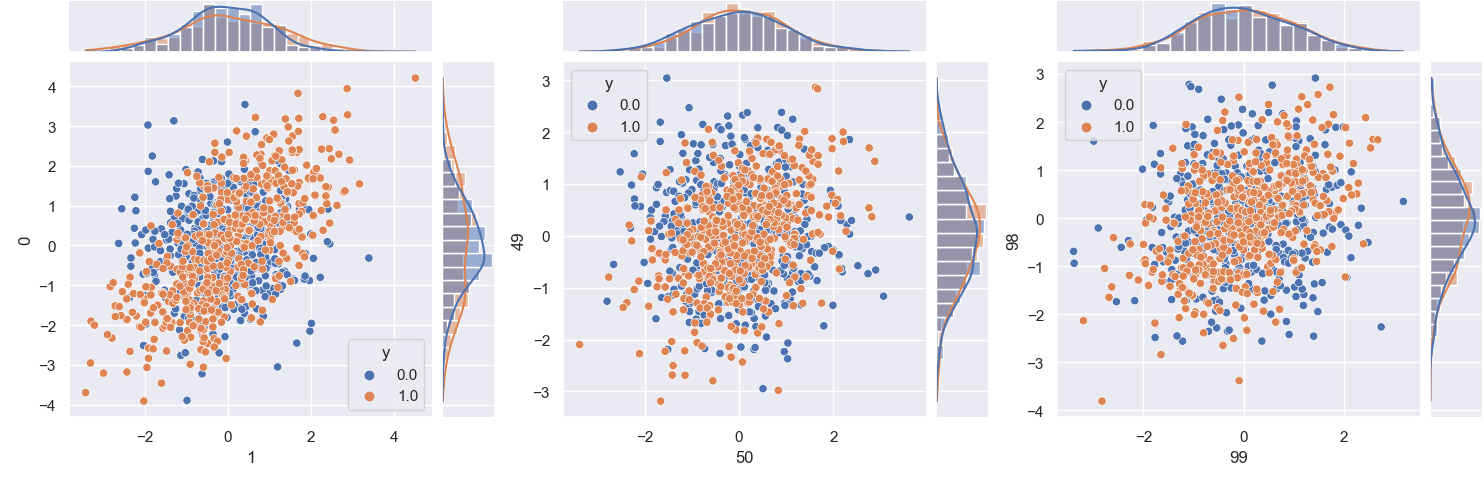

In [81]:
# scatter plot with histogram X with y as color 
plot_3joint_pairs(df)

# Skewed Unimodal

In [88]:
# Define a function to generate a dataset for the following formula:
# $$ \frac{1}{5} \mathcal{N}(\mu_0, \Sigma_0) + \frac{1}{5} \mathcal{N}(\mu_1, \Sigma_1) + \frac{3}{5} \mathcal{N}(\mu_2, \Sigma_2)$$
# by default, the parameters are:
# $$ \mu_0 = 0, Sigma_0 = 1, \mu_1 = \frac{1}{2}, \Sigma_1 = (\frac{2}{3})^2, \mu_2 = \frac{13}{12}, \Sigma_2 = (\frac{5}{}9)^2$$

def make_skewed_unimodal_classification(
    n_samples: int,
    n_dim: int = 10,
    mix: list = [1/5, 1/5, 3/5],
    mu_F: float = 0.0,
    mu_G0: float = 0.5,
    mu_G1: float = 13/12,
    rho_F: float = 1.0,
    rho_G0: float = (2 / 3) ** 2,
    rho_G1: float = (5 / 9) ** 2,
    band_type: str = "ma",
    shuffle: bool = False,
    return_params: bool = False,
    seed=None,
):
    """Simulate classification data from a skewed unimodal model.
    
    Skewed Unimodal is defined as three Gaussians with different means and covariances.
    $$\frac{1}{5} \mathcal{N}(\mu_0, \Sigma_0) + \frac{1}{5} \mathcal{N}(\mu_1, \Sigma_1) + \frac{3}{5} \mathcal{N}(\mu_2, \Sigma_2)$$

    Parameters
    ----------
    n_samples : int
        The number of samples to generate.
    n_dim : int, optional
        The number of dimensions in the dataset, by default 10.
    mix : list, optional
        The mixture parameter, by default [1/5, 1/5, 3/5].
    mu_F : float, optional
        The mean of the first Gaussian, by default 0.0.
    mu_G0 : float, optional
        The mean of the second Gaussian, by default 0.5.
    mu_G1 : float, optional
        The mean of the third Gaussian, by default 13/12.
    rho_F : float, optional
        The variance of the first Gaussian, by default 1.0.
    rho_G0 : float, optional
        The variance of the second Gaussian, by default (2/3)**2.
    rho_G1 : float, optional
        The variance of the third Gaussian, by default (5/9)**2.
    shuffle : bool, optional
        Whether or not to shuffle the data, by default True.
    return_params : bool, optional
        Whether or not to return the distribution parameters of the classes normal distributions.
    seed : int, optional
        Random seed, by default None.

    Returns
    -------
    X : np.ndarray of shape (n_samples, n_dim), dtype=np.float64
        First half from the Normal and the second half from the Skewed unimodal distribution as defined above.
    y : np.ndarray of shape (n_samples,), dtype=np.intp
        Labels of the dataset.
    """
    rng = np.random.default_rng(seed=seed)

    # check if the mixture parameters are valid
    if np.array(mix).sum() != 1:
        raise ValueError("Mix must sum to 1.")
    if mu_F != 0.0:
        mu_F = mu_F * np.array([1 / np.sqrt(i) for i in range(1, n_dim + 1)])
    else:
        mu_F = np.zeros(n_dim)
    # Trunk the means
    mu_G0 = mu_G0 * np.array([1 / np.sqrt(i) for i in range(1, n_dim + 1)])
    mu_G1 = mu_G1 * np.array([1 / np.sqrt(i) for i in range(1, n_dim + 1)])

    if (rho_G0 != 1.0) | (rho_G1 != 1.0):
        if band_type == "ma":
            cov_G0 = _moving_avg_cov(n_dim, rho_G0)
            cov_G1 = _moving_avg_cov(n_dim, rho_G1)
        elif band_type == "ar":
            cov_G0 = _moving_avg_cov(n_dim, rho_G0)
            cov_G1 = _moving_avg_cov(n_dim, rho_G1)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov_G0, cov_G1 = rho_G0 * np.identity(n_dim), rho_G1 * np.identity(n_dim)

    cov_F = rho_F * np.identity(n_dim)

    nF = n_samples//2
    n0, n1, n2 = (np.array(mix)*n_samples//2).astype(int)
    nG = sum((n0, n1, n2))
    
    if n_dim > 1000:
        method = "cholesky"
    else:
        method = "svd"
    
    # generate the data from the three classes
    XF = rng.multivariate_normal(mu_F, cov_F, nF, method=method)
    X0 = rng.multivariate_normal(mu_F, cov_F, n0, method=method)
    X1 = rng.multivariate_normal(mu_G0, cov_G0, n1, method=method)
    X2 = rng.multivariate_normal(mu_G1, cov_G1, n2, method=method)
    # concatenate the three arrays together
    X = np.vstack((XF, X0, X1, X2))
    # generate the labels
    y = np.concatenate((np.zeros(nF), np.ones(nG)))
    # if shuffle is true, shuffle the data
    if shuffle:
        rng.shuffle(X)
        rng.shuffle(y)

    if return_params:
        return X, y, (mu_F, mu_G0, mu_G1), (cov_F, cov_G0, cov_G1)
    return X, y



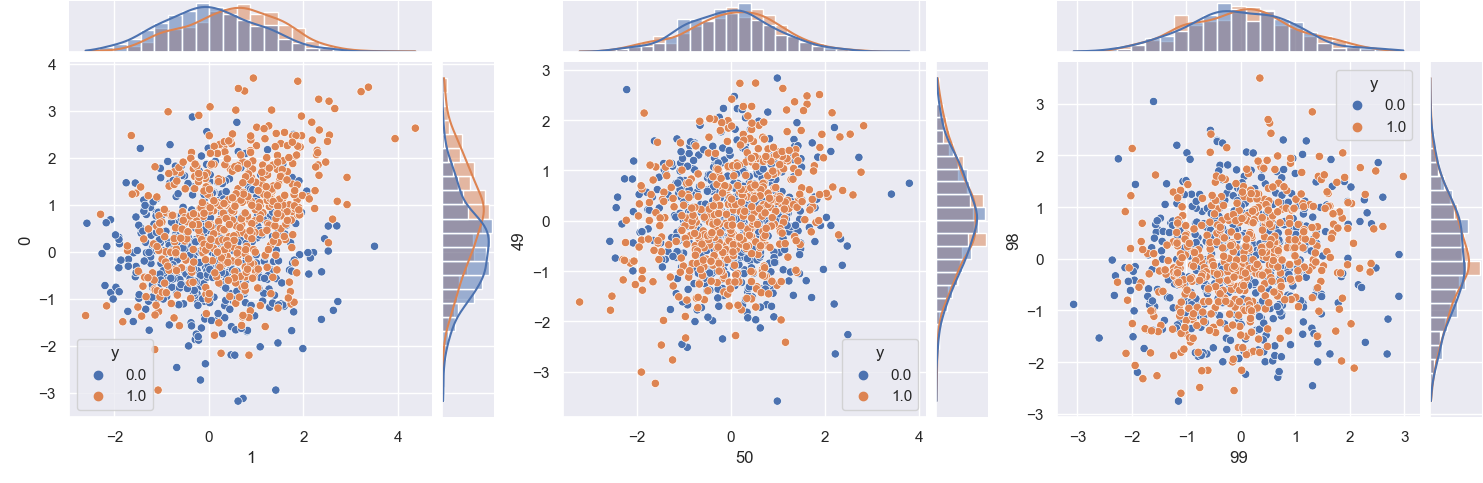

In [89]:
# test the function
X, y, (mu_0, mu_1, mu_2), (cov_0, cov_1, cov_2) = make_skewed_unimodal_classification(1000,n_dim=100, return_params=True)
# Create a df with the data
df = pd.DataFrame(X)
df['y'] = y
df.head()
plot_3joint_pairs(df)


# Strongly Skewed Classification
$ \Sigma^{7}_{l=0} \frac{1}{8} \mathcal{N}(3\{(\frac{2}{3}^l)-1\}, \frac{2}{3}^2l) $